In [1]:
# imports
import torch
import math
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, utils
from torch.optim.lr_scheduler import StepLR

from torchvision import utils
from PIL import Image
import time

import argparse
from torchvision import datasets, transforms



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
class UNet_Res(nn.Module):
    def __init__(self, input_channels, output_channels, depth=3, int_channels=16):
        super(UNet_Res, self).__init__()
        self.unetin = UNet(input_channels, int_channels)
        self.unetout = UNet(int_channels, output_channels)
        self.unets = nn.ModuleList([UNet(int_channels, int_channels) for i in range(depth)])
        self.norm = nn.InstanceNorm2d(int_channels, affine=True)

    def forward(self, x):
        x = self.unetin(x)
        x = self.norm(x)
        for unet in self.unets:
            res_input = self.norm(x)
            res_output = unet(res_input)
            res_output = self.norm(res_output)
            x = x + res_output
        x = self.unetout(x)
        return x



class Denoiser(nn.Module):
    def __init__(self,noisy_input_channels, output_channels, depth = 3):
        super(Denoiser, self).__init__()
        self.unet_res = UNet_Res(noisy_input_channels,output_channels, depth = depth)
    def forward(self,x):
        x = self.unet_res(x)
        return x


class UNet(nn.Module):
    def __init__(self, input_channels, output_channels, int_channels=16):
        super(UNet, self).__init__()

        self.conv11 = nn.Conv2d(input_channels, int_channels, kernel_size=3, stride=1, padding=1, dilation=1)
        self.conv12 = nn.Conv2d(int_channels, int_channels, kernel_size=3, stride=1, padding=1, dilation=1)

        # Second layer with dilation 2
        self.conv21 = nn.Conv2d(int_channels, int_channels, kernel_size=3, stride=1, padding=2, dilation=2)
        self.conv22 = nn.Conv2d(int_channels, int_channels, kernel_size=3, stride=1, padding=2, dilation=2)

        # Third layer with dilation 4
        self.conv31 = nn.Conv2d(int_channels, int_channels, kernel_size=3, stride=1, padding=4, dilation=4)
        self.conv32 = nn.Conv2d(int_channels, int_channels, kernel_size=3, stride=1, padding=4, dilation=4)
        self.conv33 = nn.Conv2d(int_channels, int_channels, kernel_size=3, stride=1, padding=4, dilation=4)

        self.convu21 = nn.Conv2d(int_channels, int_channels, kernel_size=3, stride=1, padding=1)
        self.convu22 = nn.Conv2d(int_channels, int_channels, kernel_size=3, stride=1, padding=1)
        self.convu11 = nn.Conv2d(int_channels, int_channels, kernel_size=3, stride=1, padding=1)
        self.convu12 = nn.Conv2d(int_channels, int_channels, kernel_size=3, stride=1, padding=1)

        # Output layer
        self.convout = nn.Conv2d(int_channels, output_channels, kernel_size=1, stride=1)
        torch.nn.init.kaiming_normal_(self.convout.weight, nonlinearity='linear')

    def forward(self, x):
        # First block
        x11 = F.relu(self.conv11(x))
        x12 = self.conv12(x11)

        # Second block with dilation
        x21 = F.relu(self.conv21(x12))
        x22 = self.conv22(x21)

        # Third block with dilation
        x31 = F.relu(self.conv31(x22))
        x32 = F.relu(self.conv32(x31))
        x33 = self.conv33(x31)

        # Upsampling path with explicit size matching
        xu20 = F.interpolate(x33, size=x22.shape[2:], mode='bilinear', align_corners=False)
        xu21 = F.relu((xu20 + x22) / math.sqrt(2))
        xu22 = F.relu(self.convu21(xu21))
        xu23 = self.convu22(xu22)

        xu10 = F.interpolate(xu23, size=x12.shape[2:], mode='bilinear', align_corners=False)
        xu11 = F.relu((xu10 + x12) / math.sqrt(2))
        xu12 = F.relu(self.convu11(xu11))
        xu13 = F.relu(self.convu12(xu12))

        # Final output layer
        out = self.convout(xu13)
        return out



In [4]:
# deuxième version

class UNet(nn.Module):
    def __init__(self, input_channels, output_channels, int_channels=16):
        super(UNet, self).__init__()

        # Convolutions with dilations
        self.conv11 = nn.Conv2d(input_channels, int_channels, kernel_size=3, stride=1, padding=1, dilation=1)
        self.conv12 = nn.Conv2d(int_channels, int_channels, kernel_size=3, stride=1, padding=1, dilation=1)

        self.conv21 = nn.Conv2d(int_channels, int_channels, kernel_size=3, stride=1, padding=2, dilation=2)
        self.conv22 = nn.Conv2d(int_channels, int_channels, kernel_size=3, stride=1, padding=2, dilation=2)

        self.conv31 = nn.Conv2d(int_channels, int_channels, kernel_size=3, stride=1, padding=4, dilation=4)
        self.conv32 = nn.Conv2d(int_channels, int_channels, kernel_size=3, stride=1, padding=4, dilation=4)
        self.conv33 = nn.Conv2d(int_channels, int_channels, kernel_size=3, stride=1, padding=4, dilation=4)

        # Pooling for downsampling
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)

        # Upsampling convolutions
        self.convu21 = nn.Conv2d(int_channels, int_channels, kernel_size=3, stride=1, padding=1)
        self.convu22 = nn.Conv2d(int_channels, int_channels, kernel_size=3, stride=1, padding=1)
        self.convu11 = nn.Conv2d(int_channels, int_channels, kernel_size=3, stride=1, padding=1)
        self.convu12 = nn.Conv2d(int_channels, int_channels, kernel_size=3, stride=1, padding=1)

        # Output layer
        self.convout = nn.Conv2d(int_channels, output_channels, kernel_size=1, stride=1)
        torch.nn.init.kaiming_normal_(self.convout.weight, nonlinearity='linear')

    def forward(self, x):
        # First block
        x11 = F.elu(self.conv11(x))
        x12 = self.conv12(x11)
        x12_pooled = self.pool(x12)  # Downsample

        # Second block
        x21 = F.elu(self.conv21(x12_pooled))
        x22 = self.conv22(x21)
        x22_pooled = self.pool(x22)  # Downsample

        # Third block
        x31 = F.elu(self.conv31(x22_pooled))
        x32 = F.elu(self.conv32(x31))
        x33 = self.conv33(x32)

        # Upsampling with bilinear interpolation
        xu20 = F.interpolate(x33, size=x22.shape[2:], mode='bilinear', align_corners=False)
        xu21 = F.elu((xu20 + x22) / math.sqrt(2))
        xu22 = F.elu(self.convu21(xu21))
        xu23 = self.convu22(xu22)

        xu10 = F.interpolate(xu23, size=x12.shape[2:], mode='bilinear', align_corners=False)
        xu11 = F.elu((xu10 + x12) / math.sqrt(2))
        xu12 = F.elu(self.convu11(xu11))
        xu13 = F.elu(self.convu12(xu12))

        # Final output
        out = self.convout(xu13)
        return out


class UNet_Res(nn.Module):
    def __init__(self, input_channels, output_channels, depth=3, int_channels=16):
        super(UNet_Res, self).__init__()
        self.unetin = UNet(input_channels, int_channels)
        self.unetout = UNet(int_channels, output_channels)
        self.unets = nn.ModuleList([UNet(int_channels, int_channels) for _ in range(depth)])
        self.norm = nn.InstanceNorm2d(int_channels, affine=True)

    def forward(self, x):
        x = self.unetin(x)
        x = self.norm(x)
        for unet in self.unets:
            res_input = self.norm(x)
            res_output = unet(res_input)
            res_output = self.norm(res_output)
            x = x + res_output
        x = self.unetout(x)
        return x


class Denoiser(nn.Module):
    def __init__(self, noisy_input_channels, output_channels, depth=4):
        super(Denoiser, self).__init__()
        self.unet_res = UNet_Res(noisy_input_channels, output_channels, depth=depth)

    def forward(self, x):
        x = self.unet_res(x)
        return x


In [5]:
def save_image(im,name):
    normalized = im-torch.min(im)
    normalized = normalized/torch.max(normalized)
    utils.save_image(normalized,name)


class dotdict(dict):
        """dot.notation access to dictionary attributes"""
        __getattr__ = dict.get
        __setattr__ = dict.__setitem__
        __delattr__ = dict.__delitem__


In [6]:
sigmas = 5*torch.pow(torch.ones(10)*0.6,torch.arange(10))
#sigmas = torch.linspace(5,0.01,15)
print(sigmas)


def forward(data, model):
    im = data

    # parameters of the langevin dynamics steps
    ind_randoms= torch.randint(0, sigmas.shape[0], (data.shape[0],), device = data.device)
    sigmas_batch = sigmas[ind_randoms]

    noise_in = torch.randn_like(im)
    im_input = (sigmas_batch[:,None,None,None]*noise_in+im)
    #im_input_norm = torch.sqrt(torch.sum(im_input**2,dim=(1,2,3)))
    #im_input_renormalized = (im_input-torch.mean(im_input,dim=(1,2,3))[:,None,None,None])/im_input_norm[:,None,None,None]
    # we append the sigmas to the model input as a new dimension of the image
    mod_input = torch.cat((im_input, sigmas_batch[:,None,None,None].expand(im.shape[0],1,im.shape[2],im.shape[3])), dim=1)

    pred_score = model(mod_input)/sigmas_batch[:,None,None,None] # we divide by sigma such that the variance
    # of the last layer is constant and equal to 1
    # corrected image using the score expression
    im_corrected = im_input+sigmas_batch[:,None,None,None]**2*pred_score

    score = -noise_in/sigmas_batch[:,None,None,None]
    square_norm = torch.sum((pred_score -score)**2,(1,2,3)) # square norm of loss per image
    loss = torch.sum(sigmas_batch**2*square_norm)
    return loss, im_input, im_corrected


def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    running_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()

        loss, im_input, im_corrected= forward(data, model)

        loss.backward()
        running_loss += loss.item()

        optimizer.step()

        if (batch_idx+1) % args.log_interval  == 0:
            running_loss = running_loss/(args.log_interval*args.batch_size)
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), running_loss))
            running_loss = 0
            if args.dry_run:
                break

nid= "vnoise"
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    ctime = time.time()
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            im = data
            loss, im_input, corr= forward(data, model)

            test_loss += loss.item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set {:.4f} Average loss: {:.4f} \n'.format(time.time()-ctime,test_loss))
    orig = im
    noisy = im_input
    save_image(noisy[:10],"/content/drive/My Drive/Télécom/3A/MVA/PGM/im/noisy.jpg")
    save_image(corr[:10],"/content/drive/My Drive/Télécom/3A/MVA/PGM/im/corrected.jpg")
    save_image(orig[:10],"/content/drive/My Drive/Télécom/3A/MVA/PGM/im/originals.jpg")
    gen_shape = list(im.shape)
    gen_shape[0] = 10
    gen_im = sampleLangevin(model, device, gen_shape)
    save_image(gen_im, "/content/drive/My Drive/Télécom/3A/MVA/PGM/im/generated.jpg")


def sampleLangevin(model,device, im_shape, epsilon = 25e-5, T=1000):
    print("generating images...")
    with torch.no_grad():
        xt = torch.randn(im_shape, device = device)*(1+sigmas[0])
        for i in range(sigmas.shape[0]):
            sigmai = sigmas[i]
            alphai = epsilon*sigmai**2/sigmas[-1]**2
            for t in range(T):
                zt = torch.randn_like(xt)
                xt_norm = torch.sqrt(torch.sum(xt**2,dim=(1,2,3)))
                xt_renormalized= (xt-torch.mean(xt, dim=(1,2,3))[:,None,None,None])/xt_norm[:,None,None,None]
                mod_input = torch.cat((xt,sigmai[None,None,None,None].expand(xt.shape[0],1,xt.shape[2],xt.shape[3])), dim=1)
                score = model(mod_input)/sigmai
                xt = xt + alphai/2*score+torch.sqrt(alphai)*zt
    print("images generated ! ")
    return xt


def main():
    global sigmas
    # Training settings
    args_dict = {'batch_size' : 64, 'test_batch_size' : 128, 'epochs' :40, 'lr' : 0.001, 'gamma' : 0.97, 'no_cuda' :False, 'dry_run':False, 'seed': 1, 'log_interval' : 200, 'save_model' :True, 'only_test':False, 'model_path':"denoiser.pt", 'load_model_from_disk':False}
    args = dotdict(args_dict)
    use_cuda = not args.no_cuda and torch.cuda.is_available()

    torch.manual_seed(args.seed)

    if use_cuda:
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")

    train_kwargs = {'batch_size': args.batch_size}
    test_kwargs = {'batch_size': args.test_batch_size}
    if use_cuda:
        cuda_kwargs = {'num_workers': 1,
                       'pin_memory': True,
                       'shuffle': True}
        train_kwargs.update(cuda_kwargs)
        test_kwargs.update(cuda_kwargs)

    # loading dataset
    """
    transform = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))#mean, std
    ])"""

    transform = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.ToTensor()  # Convert to tensor
    ])

    dataset1 = datasets.CIFAR10(root='data/', train=True, download=True, transform=transform)
    dataset2 = datasets.CIFAR10(root='data/', train=False, download=True, transform=transform)
    train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
    test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)
    # turn the images into black and white

    model = Denoiser(2,1,depth = 6).to(device)
    if args.load_model_from_disk:
        model.load_state_dict(torch.load(args.model_path, weights_only= True))
    optimizer = optim.Adam(model.parameters(), lr=args.lr)

    scheduler = StepLR(optimizer, step_size=1, gamma=args.gamma)

    sigmas = sigmas.to(device)
    for epoch in range(1, args.epochs + 1):
        if not args.only_test:
            train(args, model , device, train_loader, optimizer, epoch)
            scheduler.step()
        test(model,  device, test_loader)

    if args.save_model:
        torch.save(model.state_dict(), args.model_path)


main()

tensor([5.0000, 3.0000, 1.8000, 1.0800, 0.6480, 0.3888, 0.2333, 0.1400, 0.0840,
        0.0504])


100%|██████████| 170M/170M [00:13<00:00, 12.9MB/s]


Extracting data/cifar-10-python.tar.gz to data/
Files already downloaded and verified
Train Epoch: 1 [12736/50000 (25%)]	Loss: 198.047163
Train Epoch: 1 [25536/50000 (51%)]	Loss: 126.228694
Train Epoch: 1 [38336/50000 (77%)]	Loss: 117.889014

Test set 3.3142 Average loss: 118.8826 

generating images...
images generated ! 
Train Epoch: 2 [12736/50000 (25%)]	Loss: 114.255603
Train Epoch: 2 [25536/50000 (51%)]	Loss: 109.654721
Train Epoch: 2 [38336/50000 (77%)]	Loss: 110.411945

Test set 2.7968 Average loss: 109.3127 

generating images...
images generated ! 
Train Epoch: 3 [12736/50000 (25%)]	Loss: 108.609544
Train Epoch: 3 [25536/50000 (51%)]	Loss: 107.452848
Train Epoch: 3 [38336/50000 (77%)]	Loss: 107.048689

Test set 2.8100 Average loss: 106.9657 

generating images...
images generated ! 
Train Epoch: 4 [12736/50000 (25%)]	Loss: 106.818873
Train Epoch: 4 [25536/50000 (51%)]	Loss: 105.132297
Train Epoch: 4 [38336/50000 (77%)]	Loss: 104.913916

Test set 3.1680 Average loss: 104.9136 


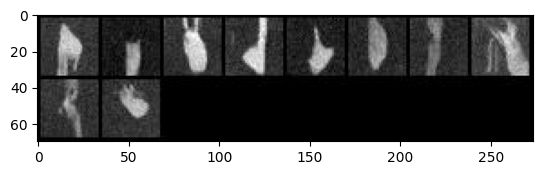

In [7]:
from matplotlib.pyplot import imread
import matplotlib.pyplot as plt

im = imread("/content/drive/My Drive/Télécom/3A/MVA/PGM/im/generated.jpg")
plt.imshow(im)
plt.show()